# Tutorial 3: Matching mouse M1 cell subclasses across different sample types - scRNAseq and snRNAseq

Download data here. For how to construct the data objects, see Tutorial.

Quick facts about the datasets:

- Reference data
    - Anatomic region: healthy mouse primary motor cortex (M1)
    - Experimental platform: 10X v3
    - Sample type: single-nucleus
    - Citation: An integrated transcriptomic and epigenomic atlas of mouse primary motor cortex cell types. Data used here is part of the integrated transcriptomic and epigenomic atlas in above publication. Also used as the reference dataset in the Azimuth app.
- Query data
    - Anatomic region: healthy mouse primary motor cortex (MOp, a.k.a. M1)
    - Experimental platform: 10X v2
    - Sample type: single-cell
    - Citation: A taxonomy of transcriptomic cell types across the isocortex and hippocampal formation. Data used here is part of the mouse whole cortex taxonomy in the above publication. Also used as the demo dataset in the Azimuth app.

Load library and data.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("./FRmatch"))
import FRmatch

import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [2]:
# query data
adata_query = sc.read_h5ad("data/adata_mouse_scrna_frmatch.h5ad")
cluster_header = "cluster_membership"
sc.tl.dendrogram(adata_query, cluster_header)
adata_query

AnnData object with n_obs × n_vars = 5666 × 42
    obs: 'cluster_membership'
    uns: 'dendrogram_cluster_membership'

In [3]:
# reference data
adata_ref = sc.read_h5ad("data/adata_mouse_snrna_frmatch.h5ad")
cluster_header = "cluster_membership"
sc.tl.dendrogram(adata_ref, cluster_header)
adata_ref

AnnData object with n_obs × n_vars = 36193 × 42
    obs: 'cluster_membership'
    uns: 'dendrogram_cluster_membership'

In [4]:
# keep = ['L2_3_IT_CTX_1', 'L2_3_IT_CTX_2', "L4_5_IT_CTX"]
# adata_query = adata_query[adata_query.obs[cluster_header].isin(keep),:]
# keep = ['L2_3_IT', 'L5_IT']
# adata_ref = adata_ref[adata_ref.obs[cluster_header].isin(keep),:]

Take a look at the gene expression data distribution. We preprocessed the 10X data by taking the log1p() transformation of the raw count data, which was stored in the @assays$logcounts slot of the data object.

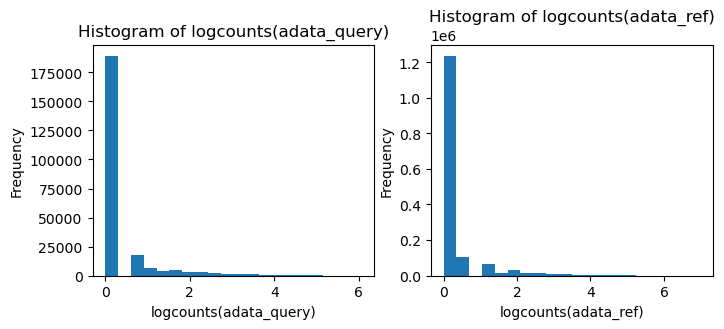

In [5]:
FRmatch.plot_logcounts(adata_query, adata_ref)

Since both datasets follow similar distribution, just take the scaling option in the normalization step.

In [6]:
adata_query_scale = FRmatch.normalization(adata_query, cluster_header)
adata_ref_scale = FRmatch.normalization(adata_ref, cluster_header)

normalizing: 100%|██████████| 23/23 [00:00<00:00, 38.63it/s]


Check again the scaled data distribution, ranging from 0 to 1.

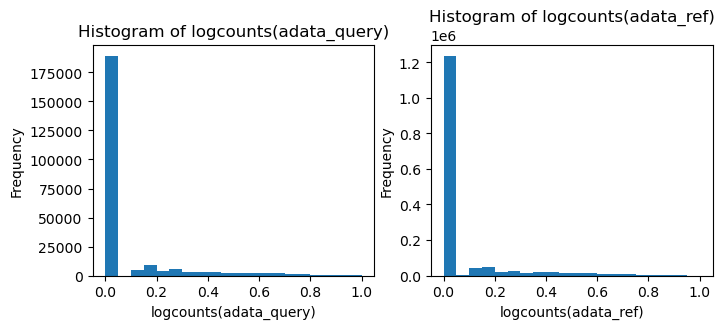

In [7]:
FRmatch.plot_logcounts(adata_query_scale, adata_ref_scale)

Take an overview of the cell type clusters in both datasets. In FR-Match, we are going to ignore the clusters with very few cells.

C:\Users\bpeng\Documents\frmatch\FRmatch\plot_clusterSize.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(dictionary.keys(), rotation = 90)
C:\Users\bpeng\Documents\frmatch\FRmatch\plot_clusterSize.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(dictionary.keys(), rotation = 90)


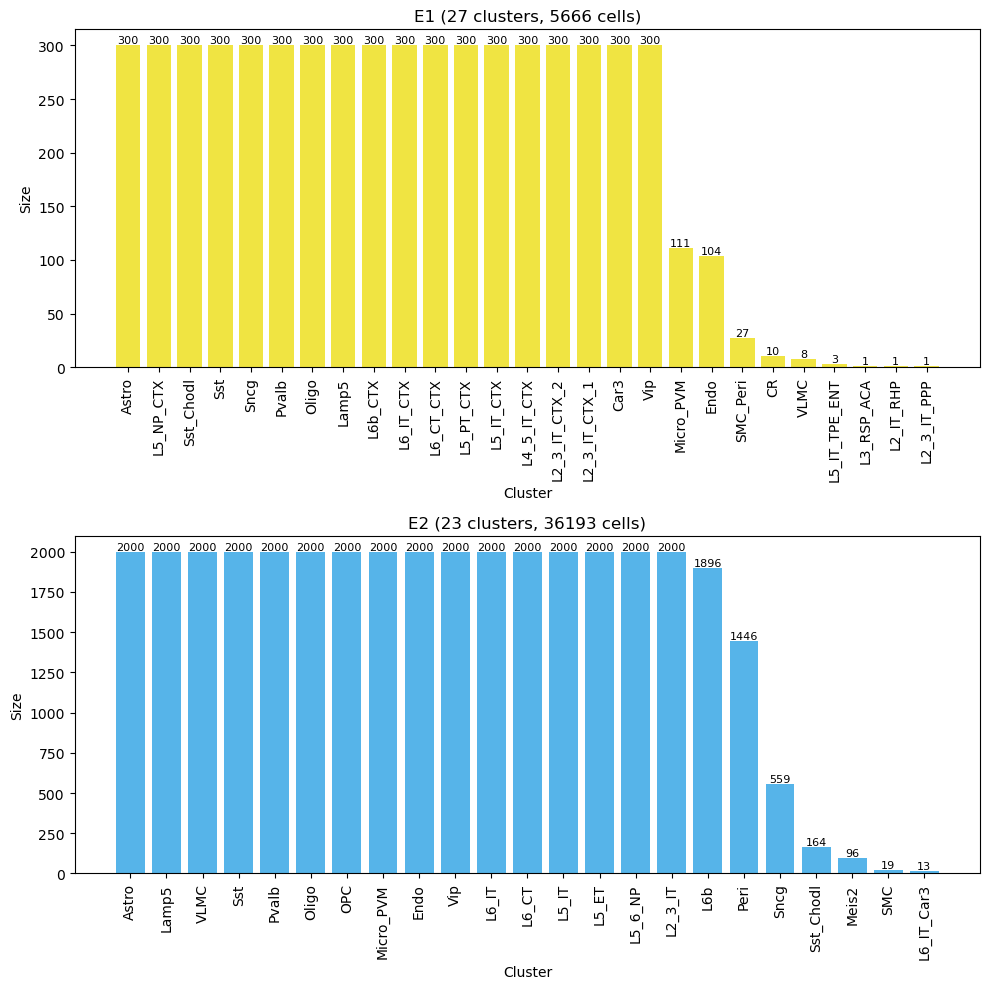

In [8]:
## cluster size
FRmatch.plot_clusterSize(adata_query, cluster_header_E1 = cluster_header, adata_E2 = adata_ref, cluster_header_E2 = cluster_header)

The following codes are suggested to plot all cell type barcode plots in an assigned folder. NOT RUN HERE.

In [9]:
# for cluster in np.unique(adata_ref_scale.obs[cluster_header]): 
#     FRmatch.plot_cluster_by_markers(adata_ref_scale, cluster_header, cluster, name_adata = "M1_10X_snRNA_", 
#                                     filename = f"plot_barcodes_M1_10X_snRNA/scale_{cluster}.png")
    
# for cluster in np.unique(adata_query_scale.obs[cluster_header]): 
#     FRmatch.plot_cluster_by_markers(adata_query_scale, cluster_header, cluster, name_adata = "M1_10X_scRNA_", 
#                                     filename = f"plot_barcodes_M1_10X_scRNA/scale_{cluster}.png")

## Run FR-Match

### Cell-to-cluster matching

Below we provide some guidance on parameter configuration.

- We ignore small clusters that have less than 5 cells (`filter_size`=5)
- For cell2cluster matching, it is recommended to use `subsamp_size`=10. Your best choice depends on your data. The choice of this parameter will impact the matching score (i.e. p-value), which is used to determine a match or unassigned match.
- `use.cosine`=True indicates to use the cosine distance instead of the Euclidean distance in the calculation, which will bring more robustness in matching between different types of samples.
- `prefix`=c("scRNAseq_","snRNAseq_") is the customizable names of your query and reference data.

In [10]:
# %%time
# results_cell2cluster = FRmatch.FRmatch_cell2cluster(adata_query, adata_ref, cluster_header_ref = cluster_header, 
#                                                     cluster_header_query = cluster_header,
#                                                     feature_selection = "reference_markers", use_cosine = True, 
#                                                     filter_size = 5, subsamp_size = 10, subsamp_iter = 2000,
#                                                     prefix = ["scRNAseq_", "snRNAseq_"], 
#                                                     save_as = "results_sctosn_R_size10_iter2000.pkl")
# # Wall time: 6min 26s - results_sctosn_R_size10_iter100
# # Wall time: 1h 10min 21s - results_sctosn_R_size10_iter1000

In [11]:
# Or preload FR-Match results
with open('results_sctosn_R_size10_iter1000.pkl', 'rb') as f: 
    results_cell2cluster_3 = pickle.load(f)
print(results_cell2cluster_3.keys())
print(results_cell2cluster_3["settings"])

dict_keys(['settings', 'results'])
{'query': 'scRNAseq_', 'ref': 'snRNAseq_', 'cluster_header_query': 'cluster_membership', 'cluster_header_ref': 'cluster_membership', 'feature_selection': 'reference_markers', 'use_cosine': True, 'filter_size': 5, 'subsamp_size': 10, 'subsamp_iter': 1000, 'subsamp_seed': 916, 'subsamp_iter_custom': False, 'subsamp_iter_custom_k': 5, 'save_as': 'results_sctosn_R_size10_iter1000.pkl'}


In [12]:
# results_cell2cluster = pd.read_csv("results_sctosn.csv")
results_cell2cluster = results_cell2cluster_3["results"].copy()

# query cluster order
order = ['CR', 'Lamp5', 'Sncg', 'Vip', 'Sst_Chodl', 'Sst', 'Pvalb', 'L2_3_IT_CTX_1', 'L2_3_IT_CTX_2', 'L4_5_IT_CTX', 
         'L5_IT_CTX', 'L6_IT_CTX', 'Car3', 'L5_PT_CTX', 'L6_CT_CTX', 'L6b_CTX', 'L5_NP_CTX', 'Astro', 'Oligo', 
         'Endo', 'SMC_Peri', 'Micro_PVM']
# check order and dendrogram have same cell types
if set(order) != set(adata_query.uns["dendrogram_cluster_membership"]["categories_ordered"]): 
    print("Missing some clusters from adata_query")
    print(set(order) - set(adata_query.uns["dendrogram_cluster_membership"]["categories_ordered"]), set(adata_query.uns["dendrogram_cluster_membership"]["categories_ordered"]) - set(order))
results_cell2cluster["query_cluster"] = results_cell2cluster["query_cluster"].astype("category")
results_cell2cluster["query_cluster"] = results_cell2cluster["query_cluster"].cat.set_categories(order)

# reference cluster order
order = ['Lamp5', 'Sncg', 'Vip', 'Sst_Chodl', 'Sst', 'Pvalb', 'L2_3_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L5_ET', 'L6_CT', 
         'L6b', 'L5_6_NP', 'Meis2', 'OPC', 'Astro', 'Oligo', 'Endo', 'VLMC', 'SMC', 'Peri', 'Micro_PVM']
if set(order) != set(adata_ref.uns["dendrogram_cluster_membership"]["categories_ordered"]): 
    print("Missing some clusters from adata_ref", set(order) - set(adata_ref.uns["dendrogram_cluster_membership"]["categories_ordered"]), set(adata_ref.uns["dendrogram_cluster_membership"]["categories_ordered"]) - set(order))
results_cell2cluster["ref_cluster"] = results_cell2cluster["ref_cluster"].astype("category")
results_cell2cluster["ref_cluster"] = results_cell2cluster["ref_cluster"].cat.set_categories(order)
results_cell2cluster = results_cell2cluster.sort_values(["ref_cluster", "query_cluster"])
results_cell2cluster

Missing some clusters from adata_query set() {'VLMC', 'L3_RSP_ACA', 'L2_3_IT_PPP', 'L5_IT_TPE_ENT', 'L2_IT_RHP'}


,index,p_value,stat,runs_samp2,runs_samp1,runs,query_cluster,ref_cluster
0,CAACTAGGTTGTGGCC_L8TX_171026_01_A04,0.029520,-1.887892,4.0,3.0,7.0,CR,Lamp5
1,AGCTCCTGTCCTCTTG_L8TX_171026_01_F04,0.029520,-1.887892,4.0,3.0,7.0,CR,Lamp5
2,ATGTGTGTCAACACAC_L8TX_171026_01_G04,0.029520,-1.887892,4.0,3.0,7.0,CR,Lamp5
3,GAAATGAAGCCACTAT_L8TX_171026_01_G04,0.029520,-1.887892,4.0,3.0,7.0,CR,Lamp5
4,CTCGGGATCCCTTGCA_L8TX_171026_01_H05,0.029520,-1.887892,4.0,3.0,7.0,CR,Lamp5
...,...,...,...,...,...,...,...,...
3,GACTAACTCCCTTGCA_L8TX_171026_01_F05,0.001607,-2.946585,3.0,3.0,4.0,NaN,Micro_PVM
4,TTGCGTCCATGGTTGT_L8TX_171026_01_H04,0.001607,-2.946585,3.0,3.0,4.0,NaN,Micro_PVM
5,ATCTACTGTCACCTAA_L8TX_171026_01_G03,0.001607,-2.946585,3.0,3.0,4.0,NaN,Micro_PVM
6,TCTTCGGTCCAAACAC_L8TX_171026_01_F04,0.001607,-2.946585,3.0,3.0,4.0,NaN,Micro_PVM


The easiest way to look at the results is to use its plot function, which shows the proportion of query cells that are matched to the reference cluster. Note that the column sum is 1.

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
def plot_cell2cluster(results): 
    
    # Sorting my query_cluster per sample's (index) p_value
    results = results.sort_values(["query_cluster", "index", "p_value"], ascending = [True, True, False])
    print(results.shape)
    # Checking for duplicated samples (index)
    results = results[~results.duplicated(["index", "query_cluster", "ref_cluster"], keep = "first")]
    print(results.shape)
    # Grouping all samples (index) by query_clusters
    results = results.pivot(index = "ref_cluster", columns = ["query_cluster", "index"], values = "p_value")
#     return results
    results = FRmatch.padj_FRmatch(results, p_adj_method = "bonferroni")
#     return results
    results = FRmatch.cutoff_FRmatch(results, p_adj_method = "bonferroni", sig_level = 0.05)
    return results
    values_max = results.max()
    results = results == values_max
    results = results.astype(int)
    results
    
    # results_2 = results.groupby(level = ["query_cluster"], axis = 1).count()
    results_2 = results.groupby(level = ["query_cluster"], axis = 1).sum()
    # results_2 = results_2.div(results_2.sum(axis=0), axis=1)
    results_2
    
    results_3 = pd.DataFrame(columns = ["ref_cluster", "query_cluster", "value"])
    results_3 = pd.DataFrame(columns = ["match", "query_cluster", "Prop"])
    for index, row in results_2.iterrows(): 
        for col in results_2.columns: 
    #         value = row[col]
            if sum(results_2[col]) == 0: value = 0
            else: value = row[col] / sum(results_2[col])
            results_3 = pd.concat([results_3, pd.DataFrame(dict(zip(results_3.columns, [index, col, value])), index = [0])])
    results_3["match"] = ["snRNAseq." + val for val in results_3["match"]]
    results_3["query_cluster"] = ["scRNAseq." + val for val in results_3["query_cluster"]]
    results_3

    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
    sns.set_theme(style="whitegrid", rc={"grid.color": "lightgray", "grid.linewidth": 0.5})
    # sns.set_theme(style="whitegrid", rc = {"axes.edgecolor": "darkgray", "xtick.bottom": True, "ytick.left": True})
    ax = sns.scatterplot(results_3, x = "query_cluster", y = "match", hue = "Prop", size = "Prop", 
                        hue_norm = (0, 1), size_norm = (0, 1), legend = "brief", 
                        sizes = (1, 200), alpha = 0.75, linewidth = 0.7, edgecolor = "gray", 
                        palette = sns.color_palette("viridis", as_cmap=True), 
                       )
    a = plt.xticks(rotation = 90)
    a = plt.legend(title = "Prop", bbox_to_anchor = (1.0, 0.7))
    return
results = plot_cell2cluster(results_cell2cluster)
results

(130318, 8)
(130318, 8)
MultiIndex([('CR', 'ACGATGTTCACATGCA_L8TX_171026_01_E05'),
            ('CR', 'AGCTCCTGTCCTCTTG_L8TX_171026_01_F04'),
            ('CR', 'ATGTGTGTCAACACAC_L8TX_171026_01_G04'),
            ('CR', 'CAACTAGGTTGTGGCC_L8TX_171026_01_A04'),
            ('CR', 'CGATCGGTCCAAACAC_L8TX_171026_01_A05'),
            ('CR', 'CGGAGCTGTGATGTCT_L8TX_171026_01_B05'),
            ('CR', 'CTAAGACAGCTACCGC_L8TX_171026_01_A05'),
            ('CR', 'CTCGGGATCCCTTGCA_L8TX_171026_01_H05'),
            ('CR', 'GAAATGAAGCCACTAT_L8TX_171026_01_G04'),
            ('CR', 'GTCATTTTCGGACAAG_L8TX_171026_01_B04'),
            ...
            ( nan, 'ATCTACTGTCACCTAA_L8TX_171026_01_G03'),
            ( nan, 'CGACCTTCACGGTAAG_L8TX_171026_01_F03'),
            ( nan, 'GACGTTATCTCAAACG_L8TX_171026_01_F03'),
            ( nan, 'GACTAACTCCCTTGCA_L8TX_171026_01_F05'),
            ( nan, 'GCTTGAATCTGGAGCC_L8TX_171026_01_H03'),
            ( nan, 'GTCATTTGTCTAACGT_L8TX_171026_01_E05'),
            ( na

CR  \
           ACGATGTTCACATGCA_L8TX_171026_01_E05   
Lamp5                                        1   
Sncg                                         1   
Vip                                          1   
Sst_Chodl                                    1   
Sst                                          1   
Pvalb                                        1   
L2_3_IT                                      1   
L5_IT                                        1   
L6_IT                                        1   
L6_IT_Car3                                   1   
L5_ET                                        1   
L6_CT                                        1   
L6b                                          1   
L5_6_NP                                      1   
Meis2                                        1   
OPC                                          1   
Astro                                        1   
Oligo                                        1   
Endo                                         1   
VLMC                                         1   
SMC                                          1   
Peri                                         1   
Micro_PVM                                    1   
unassigned                                   0   

                                                \
           AGCTCCTGTCCTCTTG_L8TX_171026_01_F04   
Lamp5                                        1   
Sncg                                         1   
Vip                                          1   
Sst_Chodl                                    1   
Sst                                          1   
Pvalb                                        1   
L2_3_IT                                      1   
L5_IT                                        1   
L6_IT                                        1   
L6_IT_Car3                                   1   
L5_ET                                        1   
L6_CT                                        1   
L6b                                          1   
L5_6_NP                                      1   
Meis2                                        1   
OPC                                          1   
Astro                                        1   
Oligo                                        1   
Endo                                         1   
VLMC                                         1   
SMC                                          1   
Peri                                         1   
Micro_PVM                                    1   
unassigned                                   0   

                                                \
           ATGTGTGTCAACACAC_L8TX_171026_01_G04   
Lamp5                                        1   
Sncg                                         1   
Vip                                          1   
Sst_Chodl                                    1   
Sst                                          1   
Pvalb                                        1   
L2_3_IT                                      1   
L5_IT                                        1   
L6_IT                                        1   
L6_IT_Car3                                   1   
L5_ET                                        1   
L6_CT                                        1   
L6b                                          1   
L5_6_NP                                      1   
Meis2                                        1   
OPC                                          1   
Astro                                        1   
Oligo                                        1   
Endo                                         1   
VLMC                                         1   
SMC                                          1   
Peri                                         1   
Micro_PVM                                    1   
unassigned                                   0   

                                                \
           CAACTAGGTTGTGGCC_L8TX_171026_01_A04   
Lamp5                                    

In [14]:
)

SyntaxError: unmatched ')' (687023194.py, line 1)

## The under-partitioned SMC_Peri cluster

In [ ]:
FRmatch.plot_cluster_by_markers(adata_query_scale, cluster_header, "SMC_Peri", markers = list(adata_query_scale.var.index), 
                                colorbar_loc = (0, 0.75), #marker_legend_loc = (1.4, 1), 
                                name_adata = "scRNA", name_markers = "NS-Forest")

In [ ]:
FRmatch.plot_cluster_by_markers(adata_ref_scale, cluster_header, "SMC", markers = list(adata_query_scale.var.index), 
                                colorbar_loc = (0, 0.75), #marker_legend_loc = (1.4, 1), 
                                name_adata = "snRNA", name_markers = "NS-Forest")

In [ ]:
FRmatch.plot_cluster_by_markers(adata_ref_scale, cluster_header, "Peri", markers = list(adata_query_scale.var.index), 
                                colorbar_loc = (0, 0.75), #marker_legend_loc = (1.4, 1), 
                                name_adata = "snRNA", name_markers = "NS-Forest")

## Available cell2cluster results

Matching results of each query cell can be accessed below.

In [ ]:
results_cell2cluster[["index", "query_cluster", "ref_cluster", "p_value"]].sort_values("p_value", ascending = False).reset_index(drop = True)

In [ ]:
)

## Cluster-to-cluster matching

Though it is suggested to use slightly larger subsampling size (subsamp.size=20 by default) for the cluster-to-cluster matching. Here, we use subsamp.size=10 again in this use case. Your best setting may depend on your data, therefore we recommend to check the cluster sizes in the beginning.

In [ ]:
%%time 
results = FRmatch.FRmatch_cluster2cluster(adata_query_scale, adata_ref_scale, cluster_header_query = "cluster_membership", 
                                          cluster_header_ref = "cluster_membership", 
                                          marker_genes = list(adata_ref_scale.var.index), filter_size = 5, subsamp_size = 10)

Visualize the results. Since larger subsampling size is used and the nature of taking a cluster as a whole, the cluster-level matching is more conserved, resulting to some unassigned matches including the under-partitioned cluster.

In [ ]:
FRmatch.plot_FRmatch(results, sig_level = 0.1, marker_legend_loc = (2.5, 1))

## Other presentations of the results

We may use the following plot to look at the adjusted p-values, and choose a reasonable sig.level (red dashed line) to determine matches (above the red line) and unassigned matches (below the red line).

In [ ]:
FRmatch.plot_FRmatch(results, type_ = "padj", sig_level = 0.1, marker_legend_loc = (2.5, 1))

We can also use the prediction function to list the most similar reference cluster (i.e. highest adjusted p-value) to each query cluster, regardless the sig.level threshold.

In [ ]:
# ## top match
# predict_most_similar_cluster(rst)

## Minimum spanning tree plots

Lastly, we can also use the minimum spanning tree (MST) plot to diagnose the under-partitioned cluster and its partial matches.

In [ ]:
# plot_MST(sce.query.scale, sce.ref.scale, "SMC_Peri", "SMC", use.cosine=T)

In [ ]:
# plot_MST(sce.query.scale, sce.ref.scale, "SMC_Peri", "Peri", use.cosine=T)